# Discrete version of CartPole

In this notebook, we will use the same environment, but we will discretize the state to use a basic Q-Learning algo (without neural networks)

In [6]:
# Imports
import sys
import math
from collections import Counter
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
#!pip install gym shortprint  pyglet --quiet
import gym
from gym.wrappers import Monitor

# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

#sns.set_palette('brg')  

In [7]:
env = gym.make("CartPole-v0")

Just to remember, here are the different observations and their ranges. It corresponds to the states

    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8*                 | 4.8*                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |

[-4.8        -5.         -0.41887903 -0.87266463]
[4.8        5.         0.41887903 0.87266463]


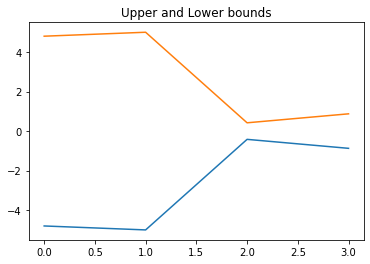

In [103]:
# Discretize the env
DISCRET_NBR = [1, 1, 10, 6] # Number of values per dimension of the state

env_low = env.observation_space.low
env_high = env.observation_space.high
env_low[1], env_high[1] = -5, 5
env_low[3], env_high[3] = -math.radians(50), math.radians(50)
print(env_low)
print(env_high)
plt.plot(env_low)
plt.plot(env_high)
plt.title("Upper and Lower bounds");

First of all, we will have to define the boundaries of the different dimensions of the observations. For the cart velocity and the pole angular velocity, we have to define them using the continuous version of the cart pole (in the other notebook), and basically search for the observed max and min during the training. That way, it is possible to pick the different discrete values


The function below `convert_state_discrete` will convert a continuous state (provided by the cartpole environment and convert it to a tuple of ints) (we will see later why  a tuple of ints and not just one int)

In [104]:
def convert_state_discrete(state):
    bucket_indice = []
    for state_idx in range(len(state)):
        if state[state_idx] <= env_low[state_idx]:
            bucket_index = 0
        elif state[state_idx] >= env_high[state_idx]:
            bucket_index = DISCRET_NBR[state_idx] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = env_high[state_idx] - env_low[state_idx]
            offset = (DISCRET_NBR[state_idx] - 1) * env_low[state_idx] / bound_width
            scaling = (DISCRET_NBR[state_idx] - 1) / bound_width
            bucket_index = int(round(scaling * state[state_idx] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


In [105]:
convert_state_discrete([0.1, 0.1, 0.1, 0.1])

(0, 0, 6, 3)

The below function will evaluate the Q table using a Monte Carlo approach (by simulating several episodes)

In [106]:
def eval_q(env, Q, n_sim=5):
    """Use Monte Carlo evaluation."""
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for episode_id in range(n_sim):
        state = env_copy.reset()
        state = convert_state_discrete(state)
        done = False
        while not done:
            action = Q[state].argmax()
            state, reward, done, _ = env_copy.step(action)
            state = convert_state_discrete(state)
            episode_rewards[episode_id]+=reward
    return episode_rewards

The exploration rates and learning rates will evolve over time, using a log. We have set boundaries to be sure we always explore a bit and learn also ;)

In [107]:
def get_explore_rate(t):
    return max(0.01, min(1, 1.0 - math.log10((t+1)/25)))

def get_learning_rate(t):
    return max(0.2, min(0.5, 1.0 - math.log10((t+1)/25)))

The trick here is to define Q as a tensor not only (state, value), but (state_1, state_2, state_3, state_4, value). That way, it is much more easier to search/select values in the table

In [108]:
def generate_Q():
    return np.zeros(tuple(DISCRET_NBR) + (2,))
generate_Q().shape

(1, 1, 10, 6, 2)

The code below search for an optimal Q using the Belmann equation. We have to be sure we discretize the state before searching the Q values associated with it

In [109]:
def select_action(Q, exploration_rate, state):
    if random.random() < exploration_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = np.argmax(Q[state])
    return action

def policy_optimisation(
    env, max_iter=100, gamma=0.99, score_every=10, verbose: bool = False
):
    """Policy optimisation."""
    Q = generate_Q()

    reached_states = Counter()
    learning_rate = get_learning_rate(0)
    exploration_rate = get_explore_rate(0)
    rewards = []

    for i in range(max_iter):
        state = env.reset()
        state = convert_state_discrete(state)
        done = False
        while not done:
            action = select_action(Q, exploration_rate, state)
            next_state, reward, done, _ = env.step(action)
            next_state = convert_state_discrete(next_state)
            reached_states.update([next_state])

            Q[state + (action,)] += learning_rate * (
                reward
                + gamma * np.amax(Q[next_state])
                - Q[state + (action,)]
            )
            state = next_state

        if i % score_every == score_every - 1:
            score = np.mean(eval_q(env, Q))
            if verbose:
                print(f"Step {i}, reward: {score}")
            rewards.append(score)
            if score > 199:
                break

        exploration_rate = get_explore_rate(i)
        learning_rate = get_learning_rate(i)
    if verbose:
        print("Reached states during training, for debugging purposes: ", reached_states)
    return Q, i, rewards


Step 9, reward: 57.2
Step 19, reward: 189.4
Step 29, reward: 11.4
Step 39, reward: 196.2
Step 49, reward: 42.0
Step 59, reward: 185.0
Step 69, reward: 187.6
Step 79, reward: 173.0
Step 89, reward: 110.6
Step 99, reward: 186.2
Step 109, reward: 164.2
Step 119, reward: 189.4
Step 129, reward: 187.6
Step 139, reward: 53.8
Step 149, reward: 200.0
Reached states during training, for debugging purposes:  Counter({(0, 0, 4, 2): 1952, (0, 0, 4, 3): 1784, (0, 0, 5, 2): 646, (0, 0, 4, 1): 636, (0, 0, 4, 4): 547, (0, 0, 5, 3): 506, (0, 0, 3, 2): 365, (0, 0, 3, 3): 337, (0, 0, 5, 1): 334, (0, 0, 5, 4): 242, (0, 0, 5, 5): 227, (0, 0, 3, 1): 216, (0, 0, 3, 0): 212, (0, 0, 6, 5): 193, (0, 0, 4, 0): 187, (0, 0, 3, 4): 118, (0, 0, 2, 0): 115, (0, 0, 7, 5): 110, (0, 0, 4, 5): 105, (0, 0, 6, 4): 101, (0, 0, 6, 3): 90, (0, 0, 5, 0): 40, (0, 0, 6, 2): 35, (0, 0, 2, 2): 26, (0, 0, 2, 1): 21, (0, 0, 6, 1): 16, (0, 0, 7, 4): 15, (0, 0, 2, 3): 14, (0, 0, 3, 5): 14, (0, 0, 7, 3): 8, (0, 0, 6, 0): 8, (0, 0, 7, 2

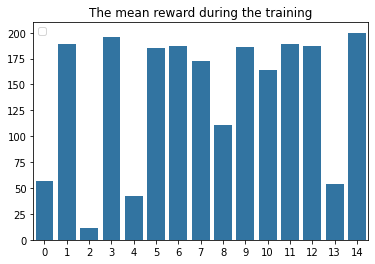

In [110]:
Q_opti, i, rewards = policy_optimisation(env, max_iter=300, verbose=True)
print(i)
sns.barplot(y=rewards, x=list(range(len(rewards))), hue=np.zeros((len(rewards),)))
plt.legend("")
plt.title("The mean reward during the training");

As we can see, the training seems to be going great ! Sometimes the rewards can go very close to 200 and then back to low values (20, ...). This is mostly due to the instability of the Q values and the discretization. With low resolutions, the model might learn by error that for the pole slightly to the right, the cart should go to the left, then the reward will fall instantly

In [111]:
print(f"Score with zeros Q")
print(eval_q(env, generate_Q()))
print(f"Score with advanced Q")
print(eval_q(env, Q_opti))

Score with zeros Q
[ 9.  9.  8. 10.  9.]
Score with advanced Q
[200. 200. 200. 200. 200.]


In [112]:
Q_opti.shape

(1, 1, 10, 6, 2)

In [113]:
video_folder = "./videos"
env_monitor = Monitor(env, video_folder, force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env_monitor.reset()
    while not done:
        state = convert_state_discrete(state)
        action = Q_opti[state].argmax()
        state, reward, done, info = env_monitor.step(action)
env_monitor.close()

from IPython.display import Video
import os
from glob import glob
Video(glob(os.path.join(video_folder, "*.mp4"))[0])

# Will not be displayed online

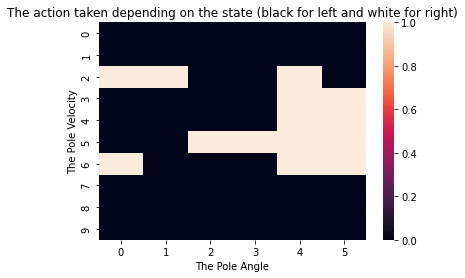

In [115]:
fig, ax = plt.subplots()
sns.heatmap(Q_opti.mean(axis=0).mean(axis=0).argmax(axis=-1), ax=ax)
ax.set_title("The action taken depending on the state (black for left and white for right)")
ax.set_xlabel("The Pole Angle")
ax.set_ylabel("The Pole Velocity")
plt.show();

This graphic shows the action depending on the pole. Basically, we can see that when the pole is leans towards left, we will go left and vice versa)

# Finding the best discretization space

We may be able to find the lowest number of states needed to achieve a great score

In [66]:
def run_one(verbose=False):
    data = {}
    # Get the params
    data['discrete_total'] = DISCRET_NBR

    for i, x in enumerate(DISCRET_NBR):
        data[f"discrete_{i}"] = x

    Q_opti, data['convergence_time'], data['rewards_over_time']  = policy_optimisation(env, max_iter=400, verbose=verbose)
    data['score'] = np.mean(eval_q(env, Q_opti, 5))
    
    return data

In [81]:
from itertools import product

initial_value = deepcopy(DISCRET_NBR)
results = []
distributions = [[1, 3, 6] for _ in range(2)] + [[1, 3, 6, 10] for _ in range(2)]
possible_value = list(product(*distributions))
tries_each = 3
with tqdm(total=len(possible_value)*tries_each, desc="Grid Search", colour="green") as pbar:
    for discrete_value in possible_value:
        for _ in range(tries_each):
            DISCRET_NBR = discrete_value
            results.append(run_one())
            pbar.update()
results = pd.DataFrame.from_records(results)
DISCRET_NBR = deepcopy(initial_value)

Grid Search: 100%|██████████| 432/432 [06:13<00:00,  1.16it/s]


In [86]:
results['minus_convergence_time'] = results['convergence_time'].apply(lambda x:-x)

In [87]:
results.head()

,discrete_total,discrete_0,discrete_1,discrete_2,discrete_3,convergence_time,rewards_over_time,score,minus_convergence_time
0,"(1, 1, 1, 1)",1,1,1,1,399,"[9.0, 9.2, 9.4, 9.0, 8.6, 9.6, 9.4, 9.0, 9.8, ...",9.4,-399
1,"(1, 1, 1, 1)",1,1,1,1,399,"[9.4, 9.6, 8.8, 9.4, 9.8, 9.8, 9.2, 9.4, 9.0, ...",8.6,-399
2,"(1, 1, 1, 1)",1,1,1,1,399,"[9.6, 9.4, 9.4, 9.8, 9.6, 9.2, 8.8, 9.4, 9.0, ...",9.0,-399
3,"(1, 1, 1, 3)",1,1,1,3,399,"[23.2, 9.8, 9.8, 9.2, 26.8, 23.6, 25.0, 21.8, ...",9.0,-399
4,"(1, 1, 1, 3)",1,1,1,3,399,"[9.4, 9.4, 23.6, 9.4, 25.0, 9.4, 9.8, 9.4, 9.4...",9.2,-399


In [88]:
results.sort_values(by="convergence_time", ascending=False).head()

,discrete_total,discrete_0,discrete_1,discrete_2,discrete_3,convergence_time,rewards_over_time,score,minus_convergence_time
0,"(1, 1, 1, 1)",1,1,1,1,399,"[9.0, 9.2, 9.4, 9.0, 8.6, 9.6, 9.4, 9.0, 9.8, ...",9.4,-399
266,"(3, 6, 6, 1)",3,6,6,1,399,"[9.4, 9.2, 9.2, 27.2, 22.2, 8.8, 36.2, 64.8, 9...",36.2,-399
264,"(3, 6, 6, 1)",3,6,6,1,399,"[8.6, 54.6, 8.8, 35.4, 38.0, 13.4, 22.0, 31.2,...",37.6,-399
263,"(3, 6, 3, 10)",3,6,3,10,399,"[20.0, 13.4, 26.2, 105.8, 23.2, 184.2, 45.6, 5...",109.6,-399
262,"(3, 6, 3, 10)",3,6,3,10,399,"[182.8, 24.6, 35.4, 47.8, 55.2, 103.8, 175.0, ...",162.8,-399


In [90]:
results.sort_values(by=["score", "minus_convergence_time"], ascending=False).head()

,discrete_total,discrete_0,discrete_1,discrete_2,discrete_3,convergence_time,rewards_over_time,score,minus_convergence_time
188,"(3, 1, 10, 6)",3,1,10,6,9,[200.0],200.0,-9
215,"(3, 3, 3, 10)",3,3,3,10,9,[200.0],200.0,-9
233,"(3, 3, 10, 3)",3,3,10,3,9,[200.0],200.0,-9
234,"(3, 3, 10, 6)",3,3,10,6,9,[200.0],200.0,-9
59,"(1, 3, 1, 10)",1,3,1,10,19,"[35.6, 200.0]",200.0,-19


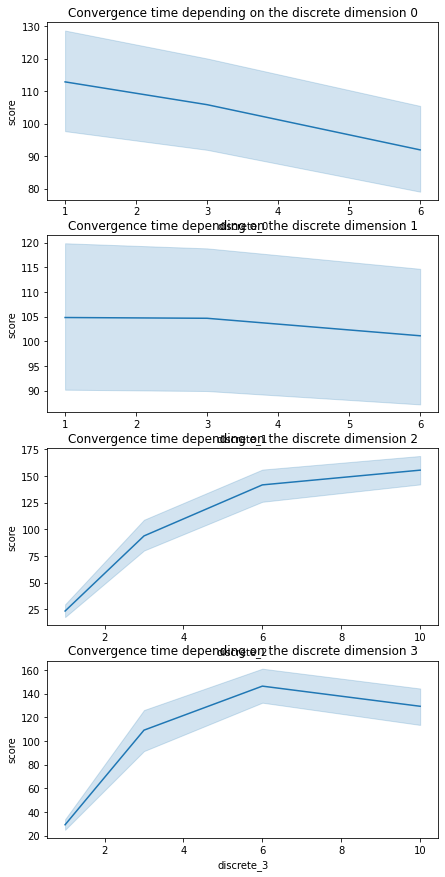

In [91]:
fig, axes = plt.subplots(4, 1, figsize=(7, 15))
for i in range(4):
    ax = axes[i]
    sns.lineplot(data=results, x=f"discrete_{i}", y="score", ax=ax)
    ax.set_title(f"Convergence time depending on the discrete dimension {i}")

From those graphics and the table below, we can say that the optimal value for each dimensions are [3, 3, 10, 3]

We can notice that for the first 2 dimensions, a value of 1 could be good enough (basically, due to the short time of the simulation, the cart is not completly random will not reach the edges of the word (left or right), so those dimensions are useless)
For the dimension 3 and 4, we almost reach the right values (for the 4th, it is 6) and for the 3rd, it is close to the correct value

In [93]:
results.groupby("discrete_total").mean().sort_values(by=["score", "minus_convergence_time"], ascending=False).head()

,discrete_0,discrete_1,discrete_2,discrete_3,convergence_time,score,minus_convergence_time
discrete_total,,,,,,,
"(3, 3, 10, 3)",3.0,3.0,10.0,3.0,19.000000,200.0,-19.000000
"(3, 1, 10, 3)",3.0,1.0,10.0,3.0,75.666667,200.0,-75.666667
"(3, 3, 6, 3)",3.0,3.0,6.0,3.0,75.666667,200.0,-75.666667
"(3, 1, 10, 6)",3.0,1.0,10.0,6.0,79.000000,200.0,-79.000000
"(1, 3, 6, 3)",1.0,3.0,6.0,3.0,82.333333,200.0,-82.333333
